In [ ]:
import torch
from torchvision import datasets
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms
import numpy as np
import os
from matplotlib.pyplot import imsave
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from torchvision.utils import save_image


In [ ]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=[0.5], std=[0.5])]
)
data = datasets.FashionMNIST(root='../data/', train=True, transform=transform, download=True)


batch_size = 64
data_loader = DataLoader(dataset=data, batch_size=batch_size, shuffle=True, drop_last=True)

In [ ]:
def get_sample_image(G, DEVICE, n_noise=100):
    img = np.zeros([280, 280])
    for j in range(10):
        z = torch.randn(10, n_noise).to(DEVICE)
        y_hat = G(z).view(10, 28, 28)
        result = y_hat.cpu().data.numpy()
        img[j*28:(j+1)*28] = np.concatenate([x for x in result], axis=-1)
    return img

In [ ]:
class Generator(nn.Module):
    def __init__(self, input_size=100, image_size=28*28):
        super(Generator, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, image_size),
            nn.Tanh()
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        y_ = self.network(x)
        y_ = y_.view(x.size(0), 1, 28, 28)
        return y_

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, input_size=28*28, num_output=1):
        super(Discriminator, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, num_output),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        y_ = self.network(x)
        return y_

In [ ]:
MODEL_NAME = 'FASHIONMNISTGAN'
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

D = Discriminator().to(DEVICE)
G = Generator().to(DEVICE)

max_epoch = 10
step = 0
n_noise = 100

criterion = nn.BCELoss()
D_opt = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
G_opt = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))


all_ones = torch.ones([batch_size, 1]).to(DEVICE)
all_zeros = torch.zeros([batch_size, 1]).to(DEVICE)

In [ ]:
# a directory to save the generated images
image_dir = "samples"
if not os.path.exists('samples'):
    os.makedirs('samples')

for epoch in range(max_epoch):
    for idx, (images, _) in enumerate(data_loader):
        x = images.to(DEVICE)
        x_outputs = D(x)
        D_x_loss = criterion(x_outputs, all_ones)
        z = torch.randn(batch_size, n_noise).to(DEVICE)
        z_outputs = D(G(z))
        D_z_loss = criterion(z_outputs, all_zeros)
        D_loss = D_x_loss + D_z_loss

        D.zero_grad()
        D_loss.backward()
        D_opt.step()

        z = torch.randn(batch_size, n_noise).to(DEVICE)
        z_outputs = D(G(z))
        G_loss = -1 * criterion(z_outputs, all_zeros)

        G.zero_grad()
        G_loss.backward()
        G_opt.step()

        if step % 500 == 0:
            print('Epoch: {}/{}, Step: {}, D Loss: {}, G Loss: {}'.format(epoch, max_epoch, step, D_loss.item(), G_loss.item()))

        if step % 1000 == 0:
            G.eval()
            z = torch.randn(batch_size, n_noise).to(DEVICE)
            fake_images = G(z)
            save_image(fake_images, os.path.join(image_dir, f'fake_images_epoch_{epoch}_step_{step}.png'), nrow=8, normalize=True)
            G.train()
        step += 1

Epoch: 0/10, Step: 0, D Loss: 1.3890632390975952, G Loss: -0.7041547298431396
Epoch: 0/10, Step: 500, D Loss: 1.1080135107040405, G Loss: -0.5299885869026184
Epoch: 1/10, Step: 1000, D Loss: 1.2889097929000854, G Loss: -0.5057607889175415
Epoch: 1/10, Step: 1500, D Loss: 1.2643721103668213, G Loss: -0.6542326807975769
Epoch: 2/10, Step: 2000, D Loss: 1.23768949508667, G Loss: -0.566868782043457
Epoch: 2/10, Step: 2500, D Loss: 1.2854290008544922, G Loss: -0.5693864822387695
Epoch: 3/10, Step: 3000, D Loss: 1.3686013221740723, G Loss: -0.5730653405189514
Epoch: 3/10, Step: 3500, D Loss: 1.3769174814224243, G Loss: -0.5948364734649658
Epoch: 4/10, Step: 4000, D Loss: 1.3297019004821777, G Loss: -0.5250337719917297
Epoch: 4/10, Step: 4500, D Loss: 1.3954777717590332, G Loss: -0.5176632404327393
Epoch: 5/10, Step: 5000, D Loss: 1.27301025390625, G Loss: -0.5596047639846802
Epoch: 5/10, Step: 5500, D Loss: 1.3089418411254883, G Loss: -0.6260687112808228
Epoch: 6/10, Step: 6000, D Loss: 1.33

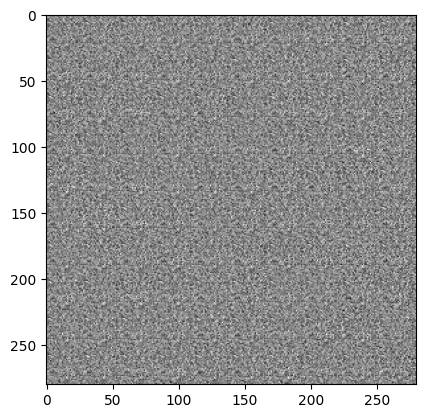

In [ ]:
img = mpimg.imread('samples/FASHIONMNIST_GAN_step000.jpg')
imgplot = plt.imshow(img)
plt.show()

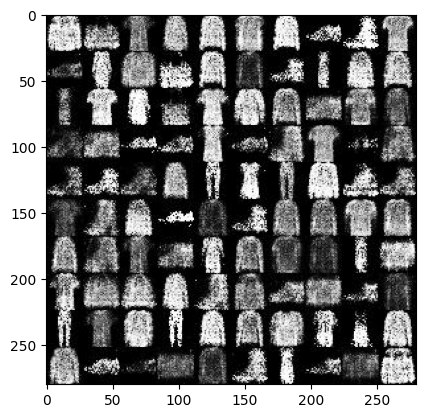

In [ ]:
img = mpimg.imread('samples/FASHIONMNISTGAN_step5000.jpg')
imgplot = plt.imshow(img)
plt.show()

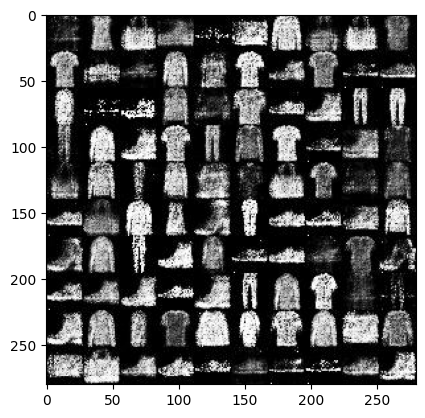

In [ ]:
img = mpimg.imread('samples/FASHIONMNISTGAN_step9000.jpg')
imgplot = plt.imshow(img)
plt.show()

And by the time we're done training, even the worst images look like messy handwriting!

In [ ]:
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

def load_images(directory):
    images = []
    for img_file in os.listdir(directory):
        img_path = os.path.join(directory, img_file)
        if os.path.isdir(img_path):
            continue  # Skip directories
        img = Image.open(img_path)
        img = np.array(img).flatten()  # Flatten the image
        images.append(img)
    return np.array(images)

real_images = load_images('real_images')
generated_images = load_images('generated_images')

labels = np.concatenate([np.ones(len(real_images)), np.zeros(len(generated_images))])

X = np.concatenate([real_images, generated_images], axis=0)
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)

clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"C2ST Accuracy: {accuracy}")

C2ST Accuracy: 0.9975


In [ ]:
from torchvision.models import inception_v3
import torch.nn.functional as F
from torch.nn.functional import adaptive_avg_pool2d
import os
import numpy as np
from PIL import Image
import torch
from torchvision import transforms
from scipy.stats import entropy

def load_and_preprocess_images(directory, target_size=(299, 299)):
    images = []
    for img_file in os.listdir(directory):
        img_path = os.path.join(directory, img_file)
        if os.path.isdir(img_path):
            continue  # Skip directories
        img = Image.open(img_path).convert('L')
        img = img.resize(target_size)
        img = np.array(img)
        img = np.stack((img,)*3, axis=-1)
        images.append(img)
    return np.array(images)

real_images = load_and_preprocess_images('real_images')
generated_images = load_and_preprocess_images('generated_images')

transform = transforms.ToTensor()
real_images = torch.stack([transform(img) for img in real_images])
generated_images = torch.stack([transform(img) for img in generated_images])


def inception_score(imgs, cuda=True, batch_size=32, resize=False, splits=1):
    """Computes the inception score of the generated images"""
    N = len(imgs)

    assert batch_size > 0
    assert N > batch_size

    if cuda:
        dtype = torch.cuda.FloatTensor
    else:
        dtype = torch.FloatTensor

    dataloader = torch.utils.data.DataLoader(imgs, batch_size=batch_size)

    inception_model = inception_v3(pretrained=True, transform_input=False).type(dtype)
    inception_model.eval();
    up = torch.nn.Upsample(size=(299, 299), mode='bilinear').type(dtype)

    def get_pred(x):
        if resize:
            x = up(x)
        x = inception_model(x)
        return F.softmax(x, dim=1).data.cpu().numpy()

    preds = np.zeros((N, 1000))

    for i, batch in enumerate(dataloader, 0):
        batch = batch.type(dtype)
        batchv = torch.autograd.Variable(batch)
        batch_size_i = batch.size()[0]

        preds[i*batch_size:i*batch_size + batch_size_i] = get_pred(batchv)

    split_scores = []

    for k in range(splits):
        part = preds[k * (N // splits): (k+1) * (N // splits), :]
        py = np.mean(part, axis=0)
        scores = []
        for i in range(part.shape[0]):
            pyx = part[i, :]
            scores.append(entropy(pyx, py))
        split_scores.append(np.exp(np.mean(scores)))

    return np.mean(split_scores), np.std(split_scores)

score, std = inception_score(generated_images, cuda=True, batch_size=32, resize=True, splits=10)
print(f'Inception Score: {score}, Std: {std}')

Inception Score: 2.744203756440489, Std: 0.154636782968957
